In [2]:
import os
import sys
sys.path.append('../src')

import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from einops import rearrange

import dzdxutils as dz
import dzdxplot as dzplt
from vit.model import ViT
from smoother.model import Smoother

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload 
%autoreload 2

/home/stock/bin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 1234

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('=> device:', device)

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

=> device: cuda


In [4]:
input_dir = '/mnt/conus3/jason_conus3/test'
results_dir = '/mnt/mlnas01/stock/'
model_name = 'complete01-vit'

xt_samples = []
v = input_dir
for f in os.listdir(v):
    if 'regA' in f and f.endswith('.npz'):
        xt_samples.append(os.path.join(v, f))
xt_samples.sort()

y_samples = []
v = os.path.join(results_dir, model_name)
for f in os.listdir(v):
    if f.endswith('.npy'):
        y_samples.append(os.path.join(v, f))
y_samples.sort()

ymax = 60.0  # value from Hilburn et al. (2020)

################################################################

def load_xty(xtf, yf, device):
    global ymax
    with np.load(xtf) as data:  # C x H x W
        x = np.expand_dims(np.flip(np.moveaxis(data['xdata'], -1, 0), axis=1), axis=0)
        t = np.expand_dims(np.flip(data['ydata'][np.newaxis, ...], axis=1), axis=0) * ymax
    y = np.expand_dims(np.flip(np.load(yf), axis=1), axis=0)  * ymax
    
    x = torch.from_numpy(x.copy()).to(device)
    
    return x, t, y

number_date_file = '/mnt/conus3/jason_conus3/sample_numbers_dates_regA_sclA.txt'
number_date_df = pd.read_csv(number_date_file, sep=' ', header=None, names=['kind', 'number', 'date'])
number_date_df.head()

kind  number               date
0  train       1  2018-04-01_00:00Z
1  train       2  2018-04-01_00:15Z
2  train       3  2018-04-01_00:30Z
3  train       4  2018-04-01_00:45Z
4  train       5  2018-04-01_01:00Z

In [5]:
date = '2022-07-02_06:00Z'
# get id from date in number_date_df
id = number_date_df[number_date_df['date'] == date]['number'].values[0] - 1
id

8763

In [6]:
x, t, y = load_xty(xt_samples[id], y_samples[id], device)
x.shape, t.shape, y.shape

(torch.Size([1, 4, 768, 1536]), (1, 1, 768, 1536), (1, 1, 768, 1536))

In [6]:
# --h-patch 12 --h-depth 4 --h-heads 8 --h-dim 64 --h-mlp-dim 128 --complete --finetune-hiddens 32 16
ckpt_pth = '/mnt/mlnas01/stock/results/complete01-vit/ckpt/complete01_vit_ckpt.pth.tar'

ckpt = torch.load(ckpt_pth, map_location=device)

# x = torch.randn(1, 4, 768, 1536).to(device)
# t = torch.randn(1, 1, 768, 1536).to(device)

backbone = ViT(image_size=x.shape[2:], patch_size=12,
            in_chans=x.shape[1], out_chans=1, dim=64,
            depth=4, heads=8, mlp_dim=128, dim_head=64)
model = Smoother(in_chans=t.shape[1], out_chans=t.shape[1],
                backbone=backbone, freezeweights=False,
                hiddens=[32, 16])
model = torch.nn.DataParallel(model).to(device)
model.load_state_dict(ckpt['model_state'])
model.eval()

print(model)
print(
    f'=> Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
# y = model(x)
# del y; torch.cuda.empty_cache()
# print(y.shape)

DataParallel(
  (module): Smoother(
    (backbone): ViT(
      (to_patch_embedding): Sequential(
        (0): Conv2d(4, 64, kernel_size=(12, 12), stride=(12, 12))
        (1): Rearrange('b d p1 p2 -> b p1 p2 d')
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (transformer): Transformer(
        (layers): ModuleList(
          (0): ModuleList(
            (0): Attention(
              (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              (attend): Softmax(dim=-1)
              (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
              (to_out): Linear(in_features=512, out_features=64, bias=False)
            )
            (1): FeedForward(
              (net): Sequential(
                (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                (1): Linear(in_features=64, out_features=128, bias=True)
                (2): GELU(approximate='none')
                (3): Dropout(p=0.2, inplace=False)
    

In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        output.retain_grad()
        activation[name] = output
    return hook

b = 1
h1 = model.module.backbone.to_patch_embedding.register_forward_hook(get_activation('patch_embed'))
h2 = model.module.backbone.transformer.layers[b][1].register_forward_hook(get_activation(f'block_{b}'))

y = model(x)
del y; torch.cuda.empty_cache(); h1.remove(); h2.remove()

patch_embed = activation['patch_embed']
block = activation[f'block_{b}'][:,0]

print(block.shape, patch_embed.shape)

# (1 x D), (1 x N x D) -> (1 x N x D)
grad = torch.autograd.grad(block, patch_embed, 
                           grad_outputs=torch.ones_like(block), 
                           retain_graph=True)[0]
print(grad.shape)
grad = rearrange(grad, 'b ... d -> b (...) d') # b, p1 * p2, d
grad[0,0] = 0
print(grad.shape, grad.min(), grad.max())

norms = abs(torch.sum(grad, dim=2).cpu().detach().numpy())
print(norms.shape, norms.min(), norms.max())
del activation; grad; patch_embed; block; torch.cuda.empty_cache()

torch.Size([1, 64]) torch.Size([1, 64, 128, 64])
torch.Size([1, 64, 128, 64])
torch.Size([1, 8192, 64]) tensor(-0.0123, device='cuda:0') tensor(0.0152, device='cuda:0')
(1, 8192) 0.0 3.7252903e-09


In [7]:
# np.save(f'/mnt/mlnas01/stock/all_token_scores_{date}.npy', all_token_scores)
all_token_scores = np.load(f'/mnt/mlnas01/stock/all_token_scores_{date}.npy')

In [8]:
all_token_scores = dz.token_distribution(model, x, remove_cls=False, 
                                         zero_self=True, norm=False)
all_token_scores.shape

100%|██████████| 8192/8192 [35:36<00:00,  3.84it/s]


(1, 4, 8192, 8192)

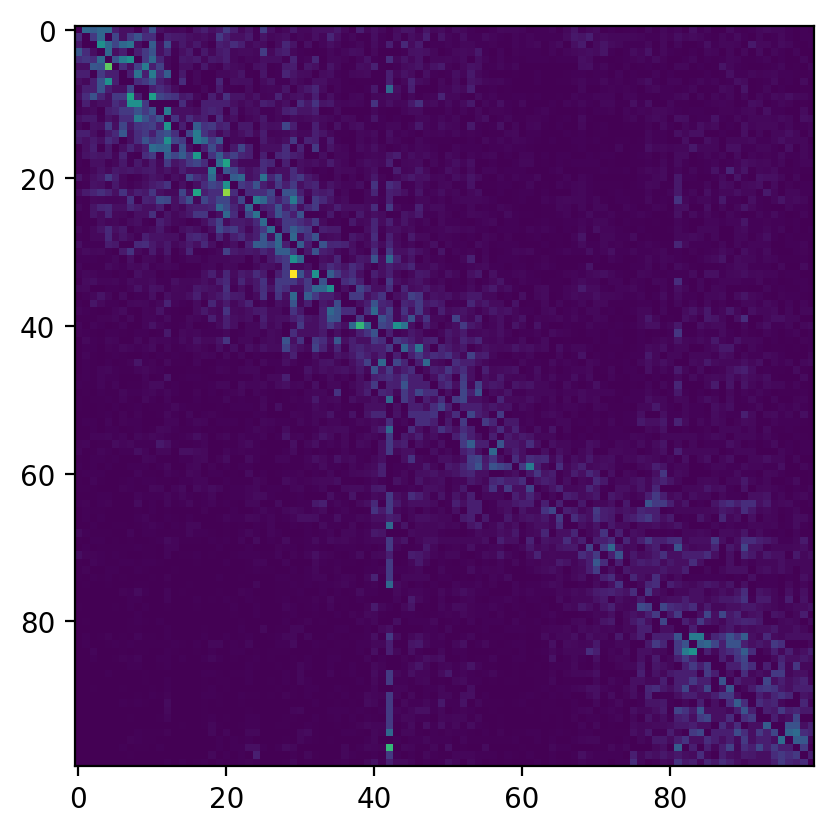

In [16]:
plt.imshow(all_token_scores[0,0,:100,:100])

In [7]:
c = 0
xc = x[0, c].detach().cpu().numpy()
tc = t[0, 0]
x.shape, xc.shape

(torch.Size([1, 4, 768, 1536]), (768, 1536))

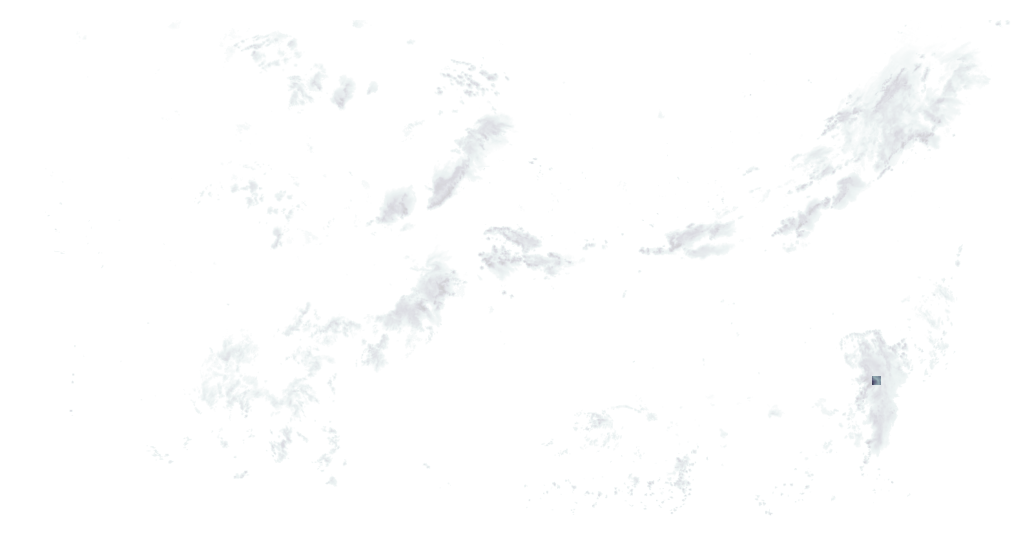

In [19]:
token_layer = 1
index = 5998 # max_std_tokens[0,token_layer]
z = dz.fill_patches([index], img_size=x.shape[2:], p=12)
z = np.ma.masked_where(z == 1, z)

plt.imshow(tc, cmap='bone_r')
plt.imshow(z, alpha=0.8, cmap='gray_r')
plt.axis('off');

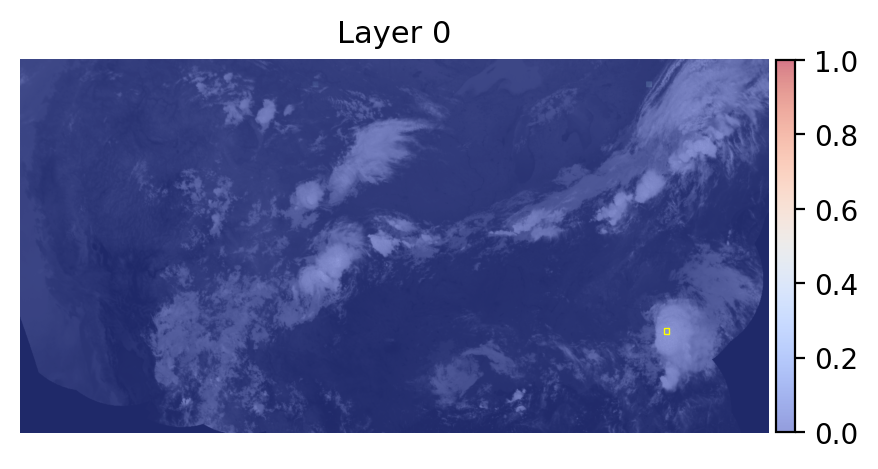

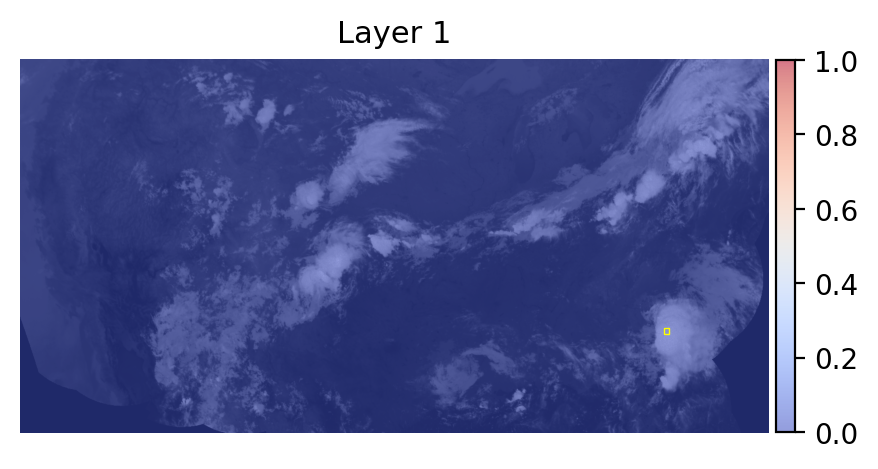

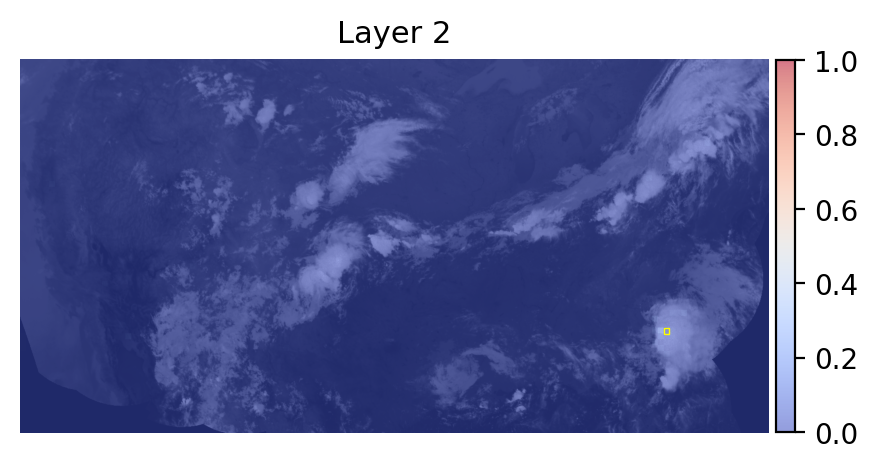

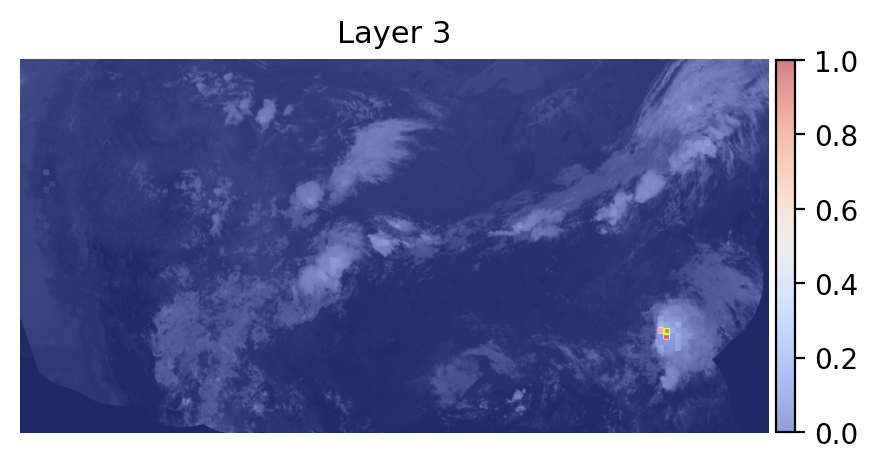

In [39]:
indices = [5998]
p = 12
minimum = all_token_scores[:,:,index].min()
maximum = all_token_scores[:,:,index].max()
for token_layer in range(all_token_scores.shape[1]):
    om = all_token_scores[:,token_layer,index]

    # normlaize between 0 and 1
    # om = (om - om.min()) / (om.max() - om.min())
    om = (om - minimum) / (maximum - minimum)
    indices = np.arange(om.shape[1])
    zs = np.zeros((x.shape[0], *x.shape[2:]))
    for i in range(zs.shape[0]):
        zs[i] = dz.fill_patches(indices, weights=om[i], 
                                img_size=x.shape[2:], p=p, z=zs[i])

    om = om[0]
    zs = zs[0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(xc, cmap='gray')
    im = ax.imshow(zs, alpha=0.55, cmap='coolwarm', vmin=0, vmax=1)

    row = index // (x.shape[-1] // p)
    col = index % (x.shape[-1] // p)
    rect = patches.Rectangle((col*p, row*p), p, p, 
                            linewidth=0.5, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)

    ax.axis('off')
    ax.set_title(f'Layer {token_layer}', fontsize=11)

    fig.colorbar(im, fraction=0.024, pad=0.01)
    # fig.savefig(f'../media/weighted_{s}_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [119]:
x.shape

torch.Size([1, 4, 768, 1536])

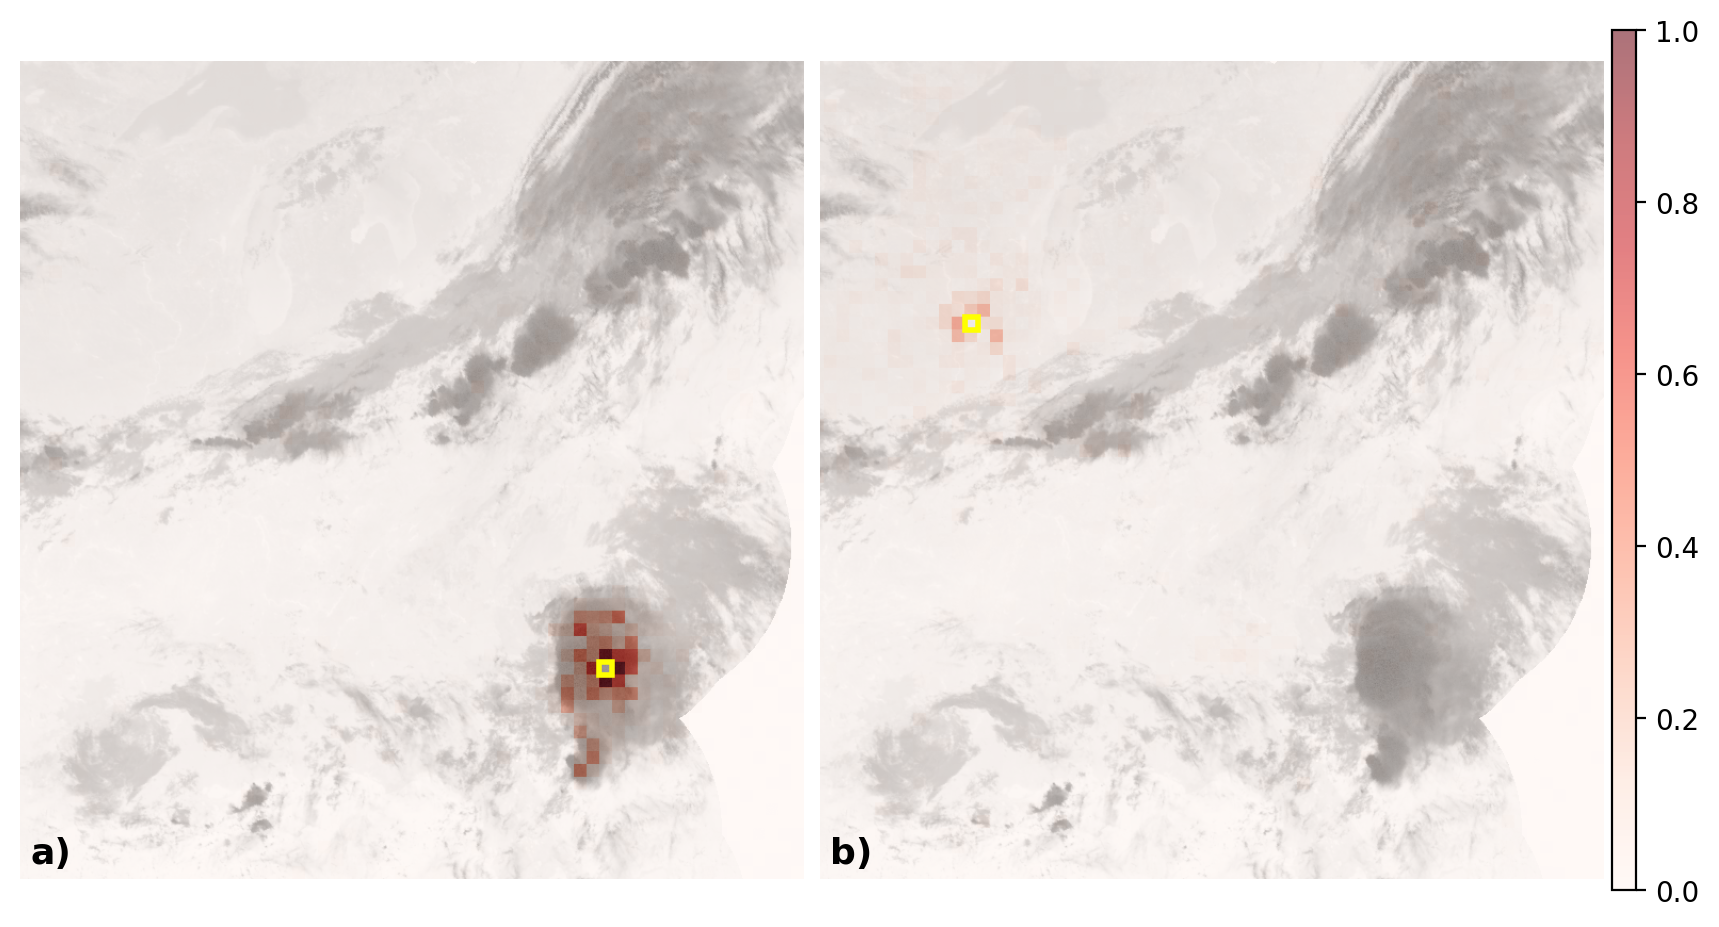

In [123]:
inds = [6128, 2638]
oms = all_token_scores[:,:,inds].mean(axis=1)
minimum, maximum = oms.min(), oms.max()

# normlaize between 0 and 1
oms = (oms - minimum) / (maximum - minimum)
p = 12

fig, axs = plt.subplots(1, len(inds), figsize=(8, 5), sharey=True, constrained_layout=True)
axs = np.atleast_1d(axs)
for i, index in enumerate(inds):
    om = oms[:,i]
    ax = axs[i]
    indices = np.arange(om.shape[1])
    zs = np.zeros((x.shape[0], *x.shape[2:]))
    for j in range(zs.shape[0]):
        zs[j] = dz.fill_patches(indices, weights=om[j], 
                                    img_size=x.shape[2:], p=p, z=zs[j])

    om = om[0]
    zs = zs[0]

    ax.imshow(xc, cmap='gray_r')
    im = ax.imshow(zs, alpha=0.55, cmap='Reds', vmin=0, vmax=1)

    row = index // (x.shape[-1] // p)
    col = index % (x.shape[-1] // p)
    rect = patches.Rectangle((col*p, row*p), p, p, 
                            linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(rect)

    # ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.text(0.04, 0.02, f'{chr(i + 97)})', transform=ax.transAxes,
            size=13, ha='center', weight='bold')
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.axis([800, xmax, ymin, ymax])
    
cbar_ax = fig.add_axes([1, 0.08, 0.015, .86])
fig.colorbar(im, cax=cbar_ax)
# fig.tight_layout()
# fig.colorbar(im, fraction=0.046, pad=0.04)
# fig.savefig(f'../media/mean_dzdx_{model_name}_{date}.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from mpl_toolkits.basemap import Basemap

In [9]:
c = 0
xc = np.flip(x[0, c].detach().cpu().numpy(), axis=0)
tc = np.flip(t[0, 0], axis=0)
x.shape, xc.shape

(torch.Size([1, 4, 768, 1536]), (768, 1536))

/tmp/ipykernel_2574502/2146731478.py:75: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.05,right=0.95,bottom=0.05,top=0.95)
/tmp/ipykernel_2574502/2146731478.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  _ = basemap.pcolormesh(xlon,ylat,xnan,cmap=sat_cmap)
/tmp/ipykernel_2574502/2146731478.py:100: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = basemap.pcolormesh(xlon,ylat,znan,cmap=cmap,norm=norm,alpha=0.7)
/tmp/ipykernel_2574502/2146731478.py:111

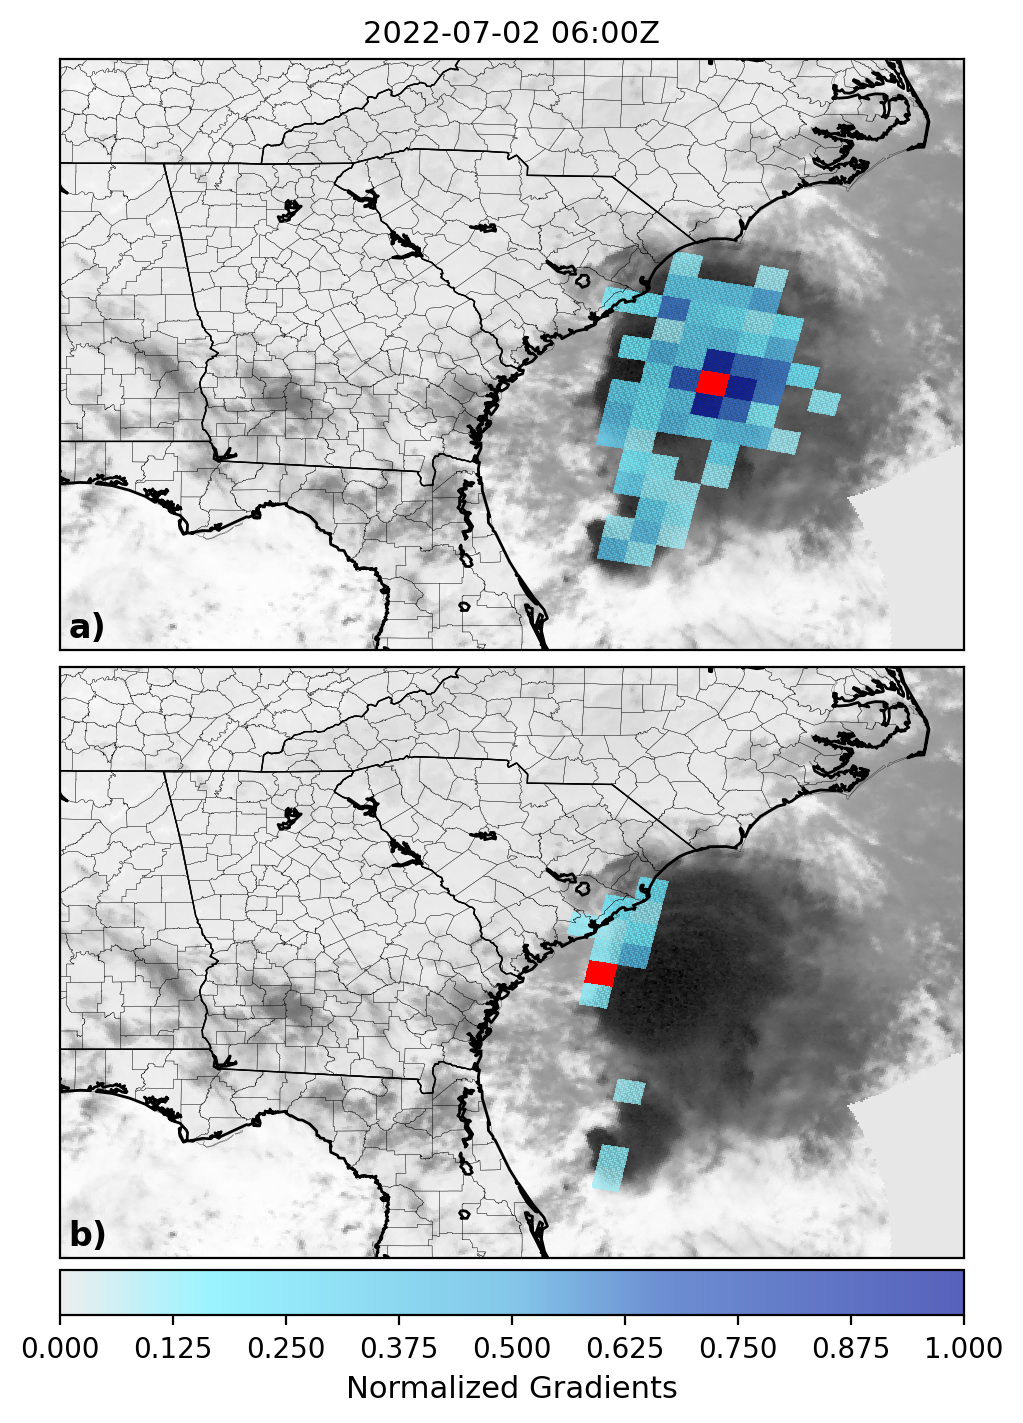

In [11]:
hrrr_grid_file = '/mnt/conus3/jason_conus3/code/hrrr_grid.bin'

nlon = 1799
nlat = 1059
count = nlat*nlon
shape = (nlat,nlon)

with open(hrrr_grid_file,'rb') as f:
    lon = np.fromfile(f,dtype=np.float64,count=count).reshape(shape)
    lat = np.fromfile(f,dtype=np.float64,count=count).reshape(shape)

#TODO: close :)
lon = lon[147:nlat-144, 153:nlon-110]
lat = lat[147:nlat-144, 153:nlon-110]

basemap = {}
basemap['projection'] = 'cyl'
basemap['resolution'] = 'i'
basemap['fix_aspect'] = False
basemap['llcrnrlon'] = -87 # lon.min()
basemap['urcrnrlon'] = -75 # lon.max()
basemap['llcrnrlat'] = 28 # lat.min()
basemap['urcrnrlat'] = 36.5 # lat.max()
basemap = Basemap(**basemap)

xlon,ylat = basemap(lon,lat)

fontsize = 11

rgb_colors = [] # new: CVD accessible
rgb_colors.append((231, 231, 231))  #0
rgb_colors.append((111, 239, 255))  #5
rgb_colors.append(( 95, 207, 239))  #10
rgb_colors.append(( 79, 175, 223))  #15
rgb_colors.append(( 47,  95, 191))  #20
rgb_colors.append(( 31,  63, 175))  #25
rgb_colors.append(( 15,  31, 159))  #30
# rgb_colors.append((247, 239,  63))  #35
# rgb_colors.append((239, 191,  55))  #40
# rgb_colors.append((231, 143,  47))  #45
# rgb_colors.append((207,  15,  23))  #50
# rgb_colors.append((183,   7,  15))  #55
# rgb_colors.append((159,   0,   8))  #60

colors = []
for atup in rgb_colors:
    colors.append('#%02x%02x%02x'%atup)

cmap = LinearSegmentedColormap.from_list('distrib', colors)
cmap.set_over(colors[-1])
# cmap.set_bad(colors[0])

sat_cmap = plt.get_cmap('gray_r')
sat_cmap.set_bad(color=colors[0])

bounds = np.linspace(0, 1, 9).tolist()
ticklabels = [f'{a:.3f}' for a in bounds]
# ticklabels[0] = '0'
# ticklabels[-1] = '1'
norm = Normalize(bounds[0], bounds[-1])

loc_cmap = ListedColormap(['red'])

#### weights ####

inds = [6128, 6124] # 6128, 6124, 6893]
oms = all_token_scores[:,:,inds].mean(axis=1)
minimum, maximum = oms.min(), oms.max()

# normlaize between 0 and 1
oms = (oms - minimum) / (maximum - minimum)
p = 12

fig = plt.figure(figsize=(5,len(inds)*3.5), constrained_layout=True)
fig.subplots_adjust(left=0.05,right=0.95,bottom=0.05,top=0.95)
for i, index in enumerate(inds):

# i = 0
# index = inds[i]

    om = oms[:,i]
    indices = np.arange(om.shape[1])
    zs = np.zeros((x.shape[0], *x.shape[2:]))
    for j in range(zs.shape[0]):
        zs[j] = dz.fill_patches(indices, weights=om[j], 
                                    img_size=x.shape[2:], p=p, z=zs[j])

    # NOTE: need to flip
    om = om[0]
    zs = np.flip(zs[0], axis=0)

    #### plot ####

    xnan = np.ma.masked_where(xc == 0.0, xc)
    znan = np.ma.masked_where(zs < 0.1, zs)

    ax = plt.subplot(len(inds), 1, 1+i)

    _ = basemap.pcolormesh(xlon,ylat,xnan,cmap=sat_cmap)
    pcm = basemap.pcolormesh(xlon,ylat,znan,cmap=cmap,norm=norm,alpha=0.7)

    basemap.drawcoastlines()
    basemap.drawcountries()
    basemap.drawstates()
    basemap.drawcounties()

    loc = dz.fill_patches([index], weights=None, img_size=x.shape[2:], p=12)
    loc = np.flip(loc, axis=0)
    zloc = np.ma.masked_where(loc == 0.0, loc)

    basemap.pcolormesh(xlon,ylat,zloc,cmap=loc_cmap)
    if i == 0 and len(inds) > 1:
        plt.title(date.replace('_', ' '), fontsize=fontsize)  
    plt.text(0.01, 0.01, f'{chr(97+i)})', transform=ax.transAxes, fontsize=fontsize+1, 
             fontweight='bold', va='bottom', ha='left', color='black')

cb = plt.colorbar(pcm,ticks=bounds,orientation='horizontal',fraction=0.1,pad=0.02)
cb.ax.set_xticklabels(ticklabels)
cb.set_label('Normalized Gradients', fontsize=fontsize)

fig.savefig(f'../media/redistribution_{date}.png', dpi=300, bbox_inches='tight')